# PARTIE 1 : Préparation des données

## Import librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, DBSCAN 
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

## Lecture des données

Nous examinons la taille des jeux de données.

Il y a 4.5 millions d'observations en 2014 et 14 millions en 2015.

Les données de 2015 ne comportent pas les informations de latitude et de longitude.

--> Nous utilisons les données de 2014 pour notre étude.

In [2]:
uber_15 = pd.read_csv('./src/uber-raw-data-janjune-15-lite.csv')
uber_15.head()

(14270479, 4)


Dispatching_base_num          Pickup_date Affiliated_base_num  locationID
0               B02617  2015-05-17 09:47:00              B02617         141
1               B02617  2015-05-17 09:47:00              B02617          65
2               B02617  2015-05-17 09:47:00              B02617         100
3               B02617  2015-05-17 09:47:00              B02774          80
4               B02617  2015-05-17 09:47:00              B02617          90

In [3]:
uber_1409 = pd.read_csv('./src/uber-raw-data-sep14.csv')
uber_1408 = pd.read_csv('./src/uber-raw-data-aug14.csv')
uber_1407 = pd.read_csv('./src/uber-raw-data-jul14.csv')
uber_1406 = pd.read_csv('./src/uber-raw-data-jun14.csv')
uber_1405 = pd.read_csv('./src/uber-raw-data-may14.csv')
uber_1404 = pd.read_csv('./src/uber-raw-data-apr14.csv')

In [4]:
uber_1409.head()

Date/Time      Lat      Lon    Base
0  9/1/2014 0:01:00  40.2201 -74.0021  B02512
1  9/1/2014 0:01:00  40.7500 -74.0027  B02512
2  9/1/2014 0:03:00  40.7559 -73.9864  B02512
3  9/1/2014 0:06:00  40.7450 -73.9889  B02512
4  9/1/2014 0:11:00  40.8145 -73.9444  B02512

In [5]:
print(uber_1409.shape)
print(uber_1408.shape)
print(uber_1407.shape)
print(uber_1406.shape)
print(uber_1405.shape)
print(uber_1404.shape)
print('Total of rows for 2014:', len(uber_1409)+len(uber_1408)+len(uber_1407)+len(uber_1406)+len(uber_1405)+len(uber_1404))

(1028136, 4)
(829275, 4)
(796121, 4)
(663844, 4)
(652435, 4)
(564516, 4)
Total of rows for 2014: 4534327


## Concaténer les données 2014

Nous concaténons toutes les données 2014.

Nous travaillons avec un échantillon de 100 000 données.

In [6]:
uber_2014 = pd.concat([uber_1404, uber_1405, uber_1406, uber_1407, uber_1408, uber_1409])
len(uber_2014)

4534327

In [7]:
uber_df = uber_2014.sample(300000)
uber_df.reset_index(drop=True, inplace=True)

In [8]:
uber_df.head()

Date/Time      Lat      Lon    Base
0  8/10/2014 14:01:00  40.7055 -74.0180  B02682
1   4/26/2014 2:12:00  40.7384 -73.9834  B02598
2  4/13/2014 23:22:00  40.7441 -73.9877  B02512
3  9/27/2014 13:38:00  40.7644 -73.9708  B02682
4   8/8/2014 19:09:00  40.7639 -73.9736  B02512

In [9]:
uber_df.shape

(300000, 4)

## Ajout de colonnes relatives à la date

In [10]:
from datetime import datetime

uber_df['date'] = ''

for index, value in enumerate(uber_df['Date/Time']):
    if value == value:
        uber_df.loc[index, 'date'] = datetime.strptime(value,'%m/%d/%Y %H:%M:%S')

In [11]:
uber_df['timestamp'] = uber_df['date'].apply(lambda x: datetime.timestamp(x))
uber_df['year'] = uber_df['date'].apply(lambda x : x.year)
uber_df['month'] = uber_df['date'].apply(lambda x : x.month)
uber_df['day'] = uber_df['date'].apply(lambda x : x.day)
uber_df['hour'] = uber_df['date'].apply(lambda x : x.hour)
uber_df['minute'] = uber_df['date'].apply(lambda x : x.minute)
uber_df['dayofweek'] = uber_df['date'].apply(lambda x : x.weekday())

In [12]:
useless_cols = ['Date/Time', 'Base']
uber_df = uber_df.drop(useless_cols, axis=1)
uber_df.head()

Lat      Lon                 date     timestamp  year  month  day  \
0  40.7055 -74.0180  2014-08-10 14:01:00  1.407672e+09  2014      8   10   
1  40.7384 -73.9834  2014-04-26 02:12:00  1.398471e+09  2014      4   26   
2  40.7441 -73.9877  2014-04-13 23:22:00  1.397424e+09  2014      4   13   
3  40.7644 -73.9708  2014-09-27 13:38:00  1.411818e+09  2014      9   27   
4  40.7639 -73.9736  2014-08-08 19:09:00  1.407518e+09  2014      8    8   

   hour  minute  dayofweek  
0    14       1          6  
1     2      12          5  
2    23      22          6  
3    13      38          5  
4    19       9          4

## Sauvegarde fichier csv

In [13]:
uber_ml = uber_df.copy()

In [14]:
uber_ml.to_csv('./src/full_dataset_for_ml.csv', index=False)

# PARTIE 2 : Modèle KMeans

## Recherche des clusters par heure pour un jour donné

Nous utilisons l'algorithme KMeans pour trouver les clusters.

Le jeudi (dayofweek=3) est le jour le plus représenté dans notre jeu de données. 

Dans cette partie nous nous intéressons aux données pour ce jour en particulier.

In [109]:
uber_ml = pd.read_csv('./src/full_dataset_for_ml.csv')

In [110]:
uber_ml['dayofweek'].value_counts()

dayofweek
3    49822
4    49273
2    46435
1    43938
5    42685
0    35294
6    32553
Name: count, dtype: int64

In [111]:
columns_to_drop = ['date', 'timestamp', 'year', 'month', 'day', 'minute', 'dayofweek']
uber_ml_thursday = uber_ml[uber_ml['dayofweek']==3].drop(columns_to_drop, axis=1)
uber_ml_thursday.head()

Lat      Lon  hour
5   40.7692 -73.9829     7
6   40.7391 -74.0082     9
10  40.7199 -74.0001     8
13  40.7710 -73.8658    10
15  40.7588 -73.9775    21

In [112]:
hours = uber_ml_thursday['hour'].unique()
np.sort(hours)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

## Preprocessings

Nous avons uniquement des variables numériques.

Dans nos preprocessings nous avons uniquement besoin de normaliser les données.

In [113]:
print('Preprocessings on data...')
preprocessor = StandardScaler()
X = preprocessor.fit_transform(uber_ml_thursday)
print('...Done')

Preprocessings on data...
...Done


## Recherche du nombre optimal de clusters

Nous testons avec des valeurs de k entre 2 et 8.

### La méthode du coude (elbow)

In [116]:
wcss = []
for i in range(2,9):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
print(wcss)

[112374.11476403926, 86049.29800516211, 71301.23148962762, 61833.32700460091, 55835.26260433218, 47994.23092874077, 44821.11801101713]


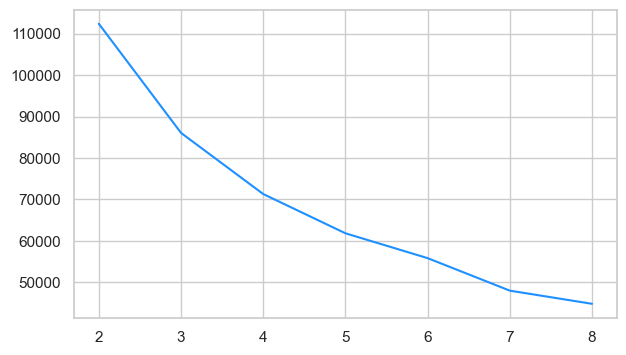

In [117]:
sns.set(rc={'figure.figsize':(7, 4)}, style='whitegrid')
sns.lineplot(x=range(2,9), y=wcss, color='dodgerblue')
plt.show() 

### Le score silhouette

In [114]:
s_score = []
for i in range(2,9):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(X)
    s_score.append(silhouette_score(X, kmeans.predict(X)))
print(s_score)

[0.34938270216453965, 0.2770565924154042, 0.34239872936742655, 0.3136705461267222, 0.3263884785502701, 0.2750800528018139, 0.3034972782085739]


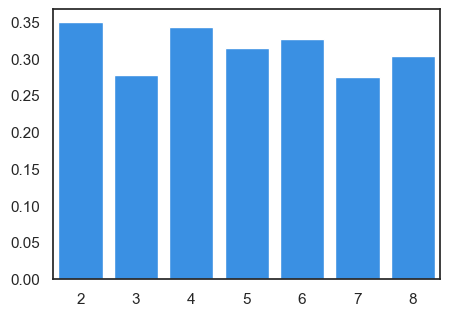

In [118]:
sns.set(rc={'figure.figsize':(5, 3.5)}, style='white')
sns.barplot(x=range(2,9), y=s_score, color='dodgerblue', width=.8)
plt.show() 

### Résultats : 

--> La méthode du coude et le score silhouette nous orientent vers une valeur optimale de 5 clusters.

## Fonction find_clusters()

Nous créons une fonction qui entraîne un modèle KMeans et retourne les prédictions et les centroïdes trouvés.

In [2]:
predictions = []
cluster_centroids = []

def find_clusters(df, hour):
    ''' Function that trains a Kmeans model and returns predicted clusters and its centroids into lists '''

    df = df[df['hour'] == hour]
    df = df.drop(['hour'], axis=1)

    preprocessor = StandardScaler()
    X = preprocessor.fit_transform(df)

    kmeans = KMeans(n_clusters=5)
    kmeans.fit(X)
    df.loc[:, 'Cluster_KMeans'] = kmeans.predict(X)
    centroids = pd.DataFrame(preprocessor.inverse_transform(kmeans.cluster_centers_[:, 0:2])) 

    predictions.append(df)
    cluster_centroids.append(centroids)

Voici en détails ce que fait la fonction : 

- On filtre les données pour l'horaire qui nous intéresse
- Puis on supprime la colonne hour
- On applique les preprocessings sur les données
- On crée et entraîne un modèle KMeans avec k=5
- On ajoute les clusters trouvés dans la colonne Cluster_KMeans
- On extrait les centroïdes dans un dataframe
- On enregistre le dataframe avec les clusters prédits dans la liste predictions
- On enregistre le dataframe avec les centroïdes dans la liste cluster_centroids

### Application de la fonction

In [120]:
for i in range(0, 24):
    find_clusters(uber_ml_thursday, hour=i)

Nous obtenons 24 dataframes avec les prédictions de clusters pour chaque heure :

- Le premier dataframe à l'index 0 correspond aux prédictions pour l'heure 0 soit entre minuit et 1h du matin.

- Le dernier dataframe à l'index 23 correspond aux prédictions pour l'heure 23 soit entre 23h et minuit.

In [121]:
print(len(predictions))
predictions[0].head()

24


Lat      Lon  Cluster_KMeans
141   40.7423 -73.9989               0
1707  40.7417 -73.9893               1
1878  40.6446 -73.7821               3
2594  40.7191 -73.9585               0
2661  40.6857 -73.9674               0

Ainsi que 24 dataframes avec les centroïdes pour chaque heure.

In [122]:
print(len(cluster_centroids))
cluster_centroids[0].head()

24


0          1
0  40.719004 -73.987386
1  40.759411 -73.970093
2  40.861540 -73.930247
3  40.646293 -73.797766
4  40.701223 -74.182931

Nous vérifions que nous avons bien toutes les prédictions pour toutes les lignes du jeu de données.

In [123]:
len(uber_ml)

300000

In [124]:
count = 0
for i in range(24):
    count += len(predictions[i])
count

49822

Nous ajoutons la colonne *Hour* dans chaque dataframe predictions et cluster_centroids.

In [125]:
for h in range(24):
    predictions[h]['Hour'] = h
    cluster_centroids[h]['Hour'] = h

In [126]:
predictions[-1].head()

Lat      Lon  Cluster_KMeans  Hour
382  40.7277 -73.9894               0    23
598  40.7547 -73.8459               1    23
599  40.6982 -73.9927               3    23
635  40.7191 -74.0089               0    23
976  40.8761 -73.8739               1    23

In [127]:
cluster_centroids[-1].head()

0          1  Hour
0  40.740865 -73.992959    23
1  40.793291 -73.918509    23
2  40.653644 -73.778610    23
3  40.696979 -73.970525    23
4  40.683022 -74.227696    23

Nous rassemblons toutes les prédictions dans un dataframe final.

In [128]:
all_predictions = pd.DataFrame(columns=['Lat', 'Lon', 'Cluster_KMeans', 'Hour'])
all_predictions = pd.concat([predictions[i] for i in range(24)])
all_predictions = all_predictions.reset_index(drop=True)

Nous rassemblons tous les centroïdes dans un dataframe final.

In [106]:
all_centroids = pd.DataFrame(columns=[0, 1, 'Hour'])
all_centroids = pd.concat([cluster_centroids[i] for i in range(24)])
all_centroids = all_centroids.reset_index(drop=True)

## Visualisation

### Zones dynamiques (hot zones)

In [129]:
import plotly.graph_objects as go

fig = go.Figure()

fig = px.scatter_mapbox(all_predictions, 
                        lat = 'Lat', 
                        lon = 'Lon',
                        color = "Cluster_KMeans",
                        color_continuous_scale=px.colors.sequential.Plasma,
                        animation_frame = "Hour",
                        animation_group = "Hour",
                        mapbox_style = "carto-positron",
                        zoom = 9.5,
                        opacity = 1)

fig.update_layout(
        title = go.layout.Title(text = "Hot zones per hour on Thursday", x = 0.5),
        showlegend = True,
        height = 600)
        
fig.show()

### Centroïdes

In [130]:
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()

fig = px.scatter_mapbox(all_centroids, 
                        lat = 0, 
                        lon = 1,
                        color_discrete_sequence = ['red'],
                        animation_frame = "Hour",
                        animation_group = "Hour",
                        mapbox_style = "carto-positron",
                        zoom = 9.5,
                        opacity = 1)

fig.update_traces(marker = {'size': 25})

fig.update_layout(
        title = go.layout.Title(text = "Hot zone's centroids per hour on Thursday", x = 0.5),
        showlegend = False,
        height = 600)
        
fig.show()

# Généralisation

Nous généralisons et cherchons les clusters pour tous les jours de la semaine.

In [3]:
uber_ml = pd.read_csv('./src/full_dataset_for_ml.csv')

In [4]:
columns_to_drop = ['date', 'timestamp', 'year', 'month', 'day', 'minute']
uber_ml.drop(columns_to_drop, axis=1, inplace=True)

In [5]:
data_per_day = []
for i in range(0,7):
    one_day = uber_ml[uber_ml['dayofweek']==i].drop(['dayofweek'], axis=1).reset_index(drop=True)
    data_per_day.append(one_day)

In [6]:
clusters_per_day = []
centroids_per_day = []

for df in data_per_day:
    predictions = []
    cluster_centroids = []
    for i in range(0, 24):
        find_clusters(df, hour=i)
    clusters_per_day.append(predictions)
    centroids_per_day.append(cluster_centroids)

Ici nous avons les prédictions de clusters pour le jeudi :

In [7]:
len(clusters_per_day[3])

24

Ici nous avons les prédictions de cluster pour le jeudi entre 23h et minuit : 

In [8]:
clusters_per_day[3][23]

Lat      Lon  Cluster_KMeans
67     40.7277 -73.9894               2
97     40.7547 -73.8459               1
98     40.6982 -73.9927               0
105    40.7191 -74.0089               0
157    40.8761 -73.8739               1
...        ...      ...             ...
49787  40.7363 -74.0082               2
49791  40.7438 -73.8559               1
49792  40.7405 -74.0077               2
49799  40.7540 -73.9822               2
49814  40.7740 -73.8731               1

[1827 rows x 3 columns]

In [9]:
for d in range(7):
    for h in range(24):
        clusters_per_day[d][h]['Hour'] = h
        clusters_per_day[d][h]['Day'] = d
        centroids_per_day[d][h]['Hour'] = h
        centroids_per_day[d][h]['Day'] = d

In [10]:
all_predictions = []
all_centroids = []

for d in range(7):
    for h in range(24):
        all_predictions.append(clusters_per_day[d][h])
        all_centroids.append(centroids_per_day[d][h])

all_predictions = pd.concat(all_predictions)
all_predictions = all_predictions.reset_index(drop=True)

all_centroids = pd.concat(all_centroids)
all_centroids = all_centroids.reset_index(drop=True)

In [11]:
display(all_predictions)
display(all_centroids)

Lat      Lon  Cluster_KMeans  Hour  Day
0       40.7140 -73.9899               0     0    0
1       40.8483 -73.9343               2     0    0
2       40.6652 -73.9509               3     0    0
3       40.7232 -73.9768               0     0    0
4       40.7414 -73.9950               0     0    0
...         ...      ...             ...   ...  ...
299995  40.7176 -74.0366               0    23    6
299996  40.8180 -73.9461               2    23    6
299997  40.5888 -73.9603               4    23    6
299998  40.7708 -73.8657               2    23    6
299999  40.6638 -73.9530               4    23    6

[300000 rows x 5 columns]

0          1  Hour  Day
0    40.741040 -73.983399     0    0
1    40.654968 -73.775497     0    0
2    40.823880 -73.912169     0    0
3    40.674548 -73.961892     0    0
4    40.691345 -74.182327     0    0
..         ...        ...   ...  ...
835  40.741261 -73.987623    23    6
836  40.651115 -73.779323    23    6
837  40.804557 -73.910323    23    6
838  40.688520 -74.178092    23    6
839  40.685941 -73.963545    23    6

[840 rows x 4 columns]

## Visualisation

Nous affichons les centroïdes des zones dynamiques entre 12h et 13h par jour de la semaine.

In [12]:
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()

fig = px.scatter_mapbox(all_centroids[all_centroids['Hour']==12], 
                        lat = 0, 
                        lon = 1,
                        color_discrete_sequence = ['red'],
                        animation_frame = "Day",
                        animation_group = "Day",
                        mapbox_style = "carto-positron",
                        zoom = 9,
                        opacity = 1)

fig.update_traces(marker = {'size': 25})

fig.update_layout(
        title = go.layout.Title(text = "Hot zone's centroids at 12pm", x = 0.5),
        showlegend = False,
        height = 600)
        
fig.show()

In [13]:
all_centroids_copy = all_centroids.copy()
all_centroids_copy['H'] = all_centroids_copy['Hour'].astype(str)
all_centroids_copy['D'] = all_centroids_copy['Day'].astype(str)
all_centroids_copy['DayHour'] = 'Day ' + all_centroids_copy['D'] + ' at ' + all_centroids_copy['H'] + 'h'
all_centroids_copy.drop(['H', 'D'], axis=1, inplace=True)

Nous affichons les centroïdes des zones dynamiques par jour et par heure de la journée.

In [14]:
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()

fig = px.scatter_mapbox(all_centroids_copy, 
                        lat = 0, 
                        lon = 1,
                        color_discrete_sequence = ['red'],
                        animation_frame = "DayHour",
                        animation_group = "DayHour",
                        mapbox_style = "carto-positron",
                        zoom = 9,
                        opacity = 1)

fig.update_traces(marker = {'size': 25})

fig.update_layout(
        title = go.layout.Title(text = "Hot zone's centroids per day and per hour", x = 0.5),
        showlegend = False,
        height = 600)

#fig['layout']['sliders'][0]['len']=1
fig.show()